In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import itertools
from scipy.stats import pearsonr
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import multiclass
from sklearn import svm
import matplotlib.pyplot as plt

In [4]:
# set path to folder containing clinic watch data
clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to folder containing home watch data
homepath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Patient Record Correlation'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [5]:
# generate task abbreviation dictionary
ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [6]:
cf = RandomForestClassifier(n_estimators = 50)
le = sklearn.preprocessing.LabelEncoder()
grouper = LeaveOneGroupOut()

In [7]:
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeatures2.csv'))
DataFeatures.head()

,SubjID,Visit,TaskAbb,Tremor,Bradykinesia,Dyskinesia,Overall,RMSX,RMSY,RMSZ,...,Sen_X,Sen_Y,Sen_Z,RMS_mag,range_mag,mean_mag,var_mag,skew_mag,kurt_mag,Sen_mag
0,1003.0,0,Drnkg,1.0,1.0,0.0,1.0,0.005253,0.008123,0.006672,...,0.959580,0.575852,0.742688,0.005957,0.897089,0.034245,0.087334,6.468010,51.769176,0.011136
1,1003.0,0,Drnkg,1.0,1.0,0.0,1.0,0.004530,0.006995,0.005352,...,1.207064,0.759448,0.988522,0.002867,0.262082,0.024327,0.038040,2.970488,10.522799,0.014210
2,1003.0,0,Drnkg,1.0,1.0,0.0,1.0,0.006019,0.012996,0.005187,...,1.194430,0.955206,1.421592,0.006851,0.752163,0.057777,0.091374,3.284491,15.761665,0.014718
3,1003.0,0,Drnkg,1.0,1.0,0.0,1.0,0.005293,0.013098,0.004630,...,1.483778,1.282091,1.750770,0.006987,0.662635,0.054590,0.095286,3.571827,14.364607,0.011343
4,1003.0,0,Drnkg,1.0,1.0,0.0,1.0,0.004878,0.007235,0.005522,...,1.343170,1.341254,1.358423,0.002959,0.244437,0.025484,0.037987,3.154667,11.324842,0.013746


In [29]:
def TrainTestModel(label_type, tasks, newLab, groups):
    '''label_type: \'TaskAbb\' or \'Tremor\' or \'Bradykinesia\' or \'Dyskinesia\' or \'Overall\' 
    tasks: list of tasks to be considered by the model; pass grouped tasks when modelling scores
    newLab: list of new labels for groups of tasks that should be considered together
    groups: list of lists containing tasks to be grouped together'''
    
    DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeatures2.csv'))
    indices = (x for x in range(len(DataFeatures)) if DataFeatures.TaskAbb.values[x] in tasks)
    DataFeatures = DataFeatures.loc[indices]
    if type(DataFeatures[label_type].values[-1]) != str:
        DataFeatures = DataFeatures[~np.isnan(DataFeatures[label_type].values)]
    if newLab:
        groupDict = {}
        for group, lab in zip(groups, newLab):
            for olab in group:
                groupDict[olab] = lab
        DataFeatures = DataFeatures[DataFeatures[label_type].apply(lambda x: groupDict[x]) != 'Excld']

#     # randomly deselect scores of 0 to prevent overfitting
#     if type(DataFeatures[label_type].values[-1]) != str:
#         sympidx = DataFeatures[label_type] != 0
#         zeroidx = DataFeatures[label_type] == 0
#         ZeroDataFeatures = DataFeatures[zeroidx]
#         ZeroDataFeatures = ZeroDataFeatures.sample(1000)
#         DataFeatures = pd.concat([DataFeatures[sympidx], ZeroDataFeatures])
#         print(len(DataFeatures))
    
    X = DataFeatures.iloc[:, 7:].values
    if newLab:
        Y = DataFeatures[label_type].apply(lambda x: groupDict[x]).values
    else:
        Y = DataFeatures[label_type].values
    
    le.fit(Y)
    Y = le.transform(Y)
    
#     # test model with training features for overfitting
#     CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
#     FeatInp = np.zeros(shape = (1, 1))
#     TrainFeat = X
#     TrainLab = Y
#     TestFeat = X
#     TestLab = Y
#     cf.fit(TrainFeat, TrainLab)
#     PredLab = cf.predict(TestFeat)
#     TestLab = le.inverse_transform(TestLab)
#     PredLab = le.inverse_transform(PredLab)
#     CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
#     for i in range(len(CM)):
#         CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100

    CM = np.zeros(shape = (len(set(Y)), len(set(Y))))
    FeatImp = np.zeros(shape = (1, 1))
    
    plt.figure(figsize = (12, 10))
    
    for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]

        TestFeat = X[testInd]
        TestLab = Y[testInd]
        
        cf.fit(TrainFeat, TrainLab)
        
        
        # GENERATE CURVE TO SHOW AUC VS TREE NUMBER: UNFINISHED 6/11
        if len(groups) == 2:
            PredLabP = []
            i = True
            treeNum = 0
            trees = []
            AUC = []
            for tree in cf.estimators_:
                treePredLab = tree.predict(TestFeat)
                treeNum += 1
                if i:
                    PredLab = treePredLab
                    ProbLab = PredLab
                    i = False
                else:
                    PredLab = np.vstack([PredLab, treePredLab])
                    ProbLab = np.mean(PredLab, axis = 0)
                try:
                    AUC = AUC + [sklearn.metrics.roc_auc_score(TestLab, ProbLab)]
                    trees = trees + [treeNum]
                except(ValueError):
                    break
        
        if trees:
            plt.plot(trees, AUC)
            plt.xlabel('Trees', fontsize = 10)
            plt.ylabel('Area Under ROC Curve', fontsize = 10)

        
        if len(FeatImp) > 1:
            FeatImp = np.vstack((FeatImp, cf.feature_importances_))
        else:
            FeatImp = cf.feature_importances_
        
        PredLab = cf.predict(TestFeat)

        TestLab = le.inverse_transform(TestLab)
        PredLab = le.inverse_transform(PredLab)

        CM = CM + sklearn.metrics.confusion_matrix(TestLab, PredLab, labels = le.classes_)
    
    plt.show()
        
    for i in range(len(CM)):
        CM[i, :] = (CM[i, :] / sum(CM[i, :])) * 100

    print('Label = ' + label_type)
    print('--------------------------------------------------')
    print('Tasks Considered:')
    for task in DataFeatures.TaskAbb.unique():
        print('    ' + ClinicTasks[task])
    if newLab:
        print('--------------------------------------------------')
        print('Label Groups:')
        for label in newLab:
            print('    ' + label)
        
    plt.figure(figsize = (12, 10))
    sns.heatmap(CM, xticklabels = le.classes_, yticklabels = le.classes_)
    plt.xlabel('Predicted', fontsize = 10)
    plt.ylabel('Test', fontsize = 10)
    
    return cf, FeatImp

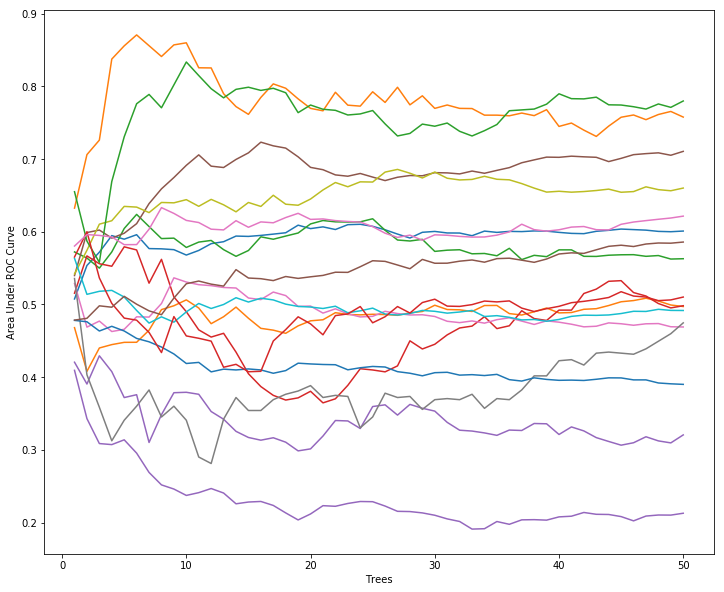

Label = Tremor
--------------------------------------------------
Tasks Considered:
    Taking a glass of water and drinking
    Folding towels
    Assembling nuts and bolts
    Organizing sheets in a folder
    Typing on a computer keyboard
--------------------------------------------------
Label Groups:
    NoSymp
    Symp


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

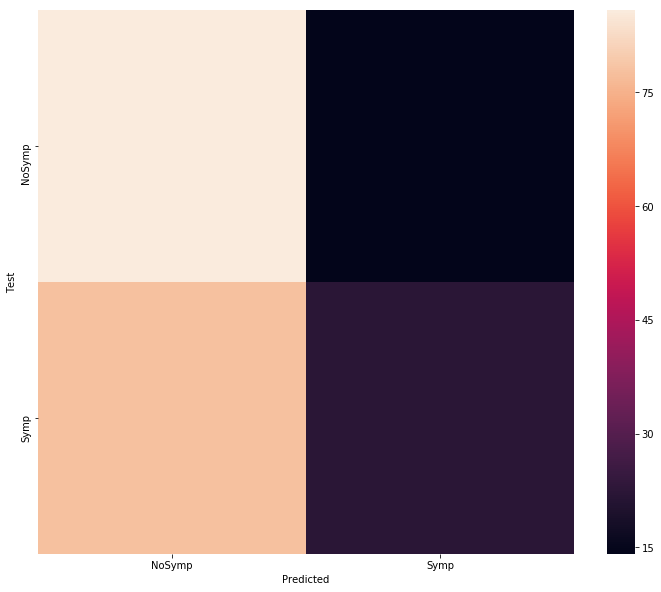

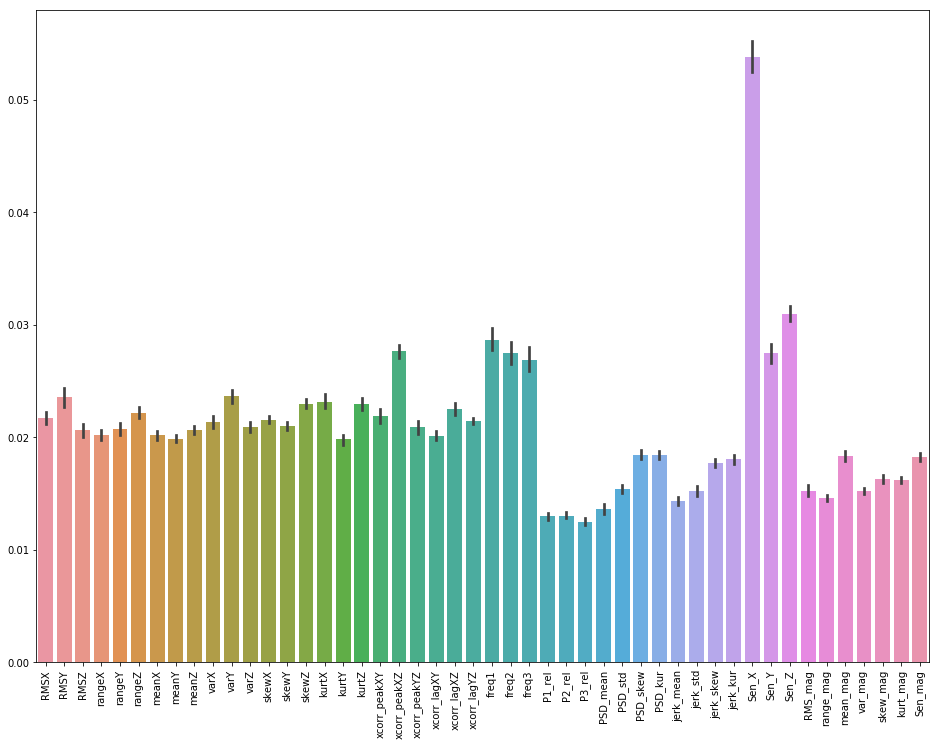

In [30]:
# # full list of tasks represented in the clinic data
# tasks = ['Drnkg', 'Drwg', 'Fldg', 'FtnL', 'FtnR', 
#          'NtsBts', 'RamL', 'RamR', 'Sheets', 'Sitng', 
#          'SitStand', 'Stndg', 'Typg', 'Wlkg', 'WlkgCnt']

# # groups of tasks for training to predict scores
# tasks = ['RamL', 'RamR']
# tasks = ['FtnL', 'FtnR']
# tasks = ['Sitng', 'Stndg', 'Drwg']
# tasks = ['Wlkg', 'WlkgCnt']
tasks = ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']

# # optimal grouping for task determination with label_type 'TaskAbb'
# newLab = ['Excld', 'Ram', 'Ftn', 'Rest', 'Wlkg', 'FinMot']
# groups = [['SitStand'], 
#           ['RamL', 'RamR'], 
#           ['FtnL', 'FtnR'],
#           ['Sitng', 'Stndg', 'Drwg'], 
#           ['Wlkg', 'WlkgCnt'], 
#           ['Fldg', 'Sheets', 'Drnkg', 'NtsBts', 'Typg']]

# # groupings for considereing lack or presence of symptoms only (for scores as label_type)
newLab = ['NoSymp', 'Symp']
groups = [[float(0)], [float(1), float(2), float(3), float(4)]]

# # leave newLab and groups lists empty to consider all present labels individually
# newLab = []
# groups = []

# label_type = 'TaskAbb'
label_type = 'Tremor'
# label_type = 'Bradykinesia'
# label_type = 'Dyskinesia'
# label_type = 'Overall'

model, FeatImp = TrainTestModel(label_type, tasks, newLab, groups)

features_list = ['RMSX', 'RMSY', 'RMSZ', 
                 'rangeX', 'rangeY', 'rangeZ', 
                 'meanX', 'meanY', 'meanZ', 
                 'varX', 'varY', 'varZ', 
                 'skewX', 'skewY', 'skewZ', 
                 'kurtX', 'kurtY', 'kurtZ', 
                 'xcorr_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ', 
                 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 
                 'freq1', 'freq2', 'freq3', # added
                 'P1_rel', 'P2_rel', 'P3_rel', # added
                 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 
                 'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur', 
                 'Sen_X', 'Sen_Y', 'Sen_Z', # not included in reduced features
                 'RMS_mag', 'range_mag', 'mean_mag', 'var_mag', 'skew_mag', 'kurt_mag', 'Sen_mag'] # not included

# features_list = ['RMSX','RMSY','RMSZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
#                 'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
#                 'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew',
#                 'PSD_kur','jerk_mean','jerk_std','jerk_skew','jerk_kur']

plt.figure(figsize = (16, 12))
sns.barplot(data = pd.DataFrame(FeatImp, columns = features_list))
plt.xticks(rotation = 90)

NameError: name 'TestLab' is not defined

In [23]:

X = DataFeatures.iloc[:, 7:].values
Y = DataFeatures['Tremor'].apply(lambda x: groupDict[x]).values
PredLabP = []
for tree in cf.estimators_:
    treePredLab = tree.predict(X)
    try:
        PredLab = np.vstack([PredLab, treePredLab])
    except(NameError, ValueError):
        PredLab = treePredLab
    try:
        PredLabP = PredLabP + list(np.mean(PredLab, axis = 1))
    except(IndexError):
        PredLabP = PredLab
    

NameError: name 'groupDict' is not defined

In [21]:
PredLabP

[array([0.34069287, 0.34069287]),
 array([0.34069287, 0.34069287, 0.35074493]),
 array([0.34069287, 0.34069287, 0.35074493, 0.33530784]),
 array([0.34069287, 0.34069287, 0.35074493, 0.33530784, 0.34311614]),
 array([0.34069287, 0.34069287, 0.35074493, 0.33530784, 0.34311614,
        0.32355053]),
 array([0.34069287, 0.34069287, 0.35074493, 0.33530784, 0.34311614,
        0.32355053, 0.33853886]),
 array([0.34069287, 0.34069287, 0.35074493, 0.33530784, 0.34311614,
        0.32355053, 0.33853886, 0.33602585]),
 array([0.34069287, 0.34069287, 0.35074493, 0.33530784, 0.34311614,
        0.32355053, 0.33853886, 0.33602585, 0.34544965]),
 array([0.34069287, 0.34069287, 0.35074493, 0.33530784, 0.34311614,
        0.32355053, 0.33853886, 0.33602585, 0.34544965, 0.33414109]),
 array([0.34069287, 0.34069287, 0.35074493, 0.33530784, 0.34311614,
        0.32355053, 0.33853886, 0.33602585, 0.34544965, 0.33414109,
        0.3537067 ]),
 array([0.34069287, 0.34069287, 0.35074493, 0.33530784, 0.343116

In [146]:
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeatures2.csv'))
X = DataFeatures.iloc[:, 7:].values
Y = DataFeatures['TaskAbb'].values

for trainInd, testInd in grouper.split(X, Y, groups = DataFeatures.SubjID.values):
        TrainFeat = X[trainInd]
        TrainLab = Y[trainInd]

        TestFeat = X[testInd]
        TestLab = Y[testInd]
        break
print(len(X))
print(len(TrainFeat))
print(len(TestFeat))

11142
10682
460


In [150]:
DataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeatures2.csv'))
list(DataFeatures.columns[7:])

['RMSX',
 'RMSY',
 'RMSZ',
 'rangeX',
 'rangeY',
 'rangeZ',
 'meanX',
 'meanY',
 'meanZ',
 'varX',
 'varY',
 'varZ',
 'skewX',
 'skewY',
 'skewZ',
 'kurtX',
 'kurtY',
 'kurtZ',
 'xcorr_peakXY',
 'xcorr_peakXZ',
 'xcorr_peakYZ',
 'xcorr_lagXY',
 'xcorr_lagXZ',
 'xcorr_lagYZ',
 'freq1',
 'freq2',
 'freq3',
 'P1_rel',
 'P2_rel',
 'P3_rel',
 'PSD_mean',
 'PSD_std',
 'PSD_skew',
 'PSD_kur',
 'jerk_mean',
 'jerk_std',
 'jerk_skew',
 'jerk_kur',
 'Sen_X',
 'Sen_Y',
 'Sen_Z',
 'RMS_mag',
 'range_mag',
 'mean_mag',
 'var_mag',
 'skew_mag',
 'kurt_mag',
 'Sen_mag']